# Import librairies

In [2]:
# Import general librairies
import numpy as np
import pandas as pd

# Import matplotlib librairies
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

# Import librairies to connect with the database
import psycopg2 as ps
import pandas.io.sql as sqlio

# Import cluster algorithms librairies
from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_score

# Import gaussian KDE
from scipy.stats import gaussian_kde

# Import Tools script
%run ../Tools.ipynb

# Connect to database

In [3]:
conn = ps.connect(dbname="SLA", user="postgres", password="root", host="localhost", port="5432")

# Get data from database

In [4]:
# Label to assign data points
label = 'GROUPEDEB'

# Set sql query
sql = 'SELECT * FROM "PATIENTS"'

# Get data from database
df_patients = sqlio.read_sql_query(sql, conn).copy()
print("Nombre de patients restant :", df_patients.shape[0])

C:\Users\guill\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Nombre de patients restant : 1045


# Label categorical data

In [4]:
df_patients[label] = labelData(df_patients[label])

# Drop "Respiratoire" Diagnostic

In [5]:
df_patients = df_patients[df_patients.GROUPEDEB != "Respiratoire"]
print("Nombre de patients restant :", df_patients.shape[0])

Nombre de patients restant : 1018


# Separate numerical and nominal variable

In [6]:
# Get numerical variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = df_patients.select_dtypes(include=numerics)

# Get nominal variable
y = df_patients[label]

# Scale data

In [7]:
# Scale data
X_scaled = (X - X.min())/ (X.max() - X.min())

# Kernel Density Estimator

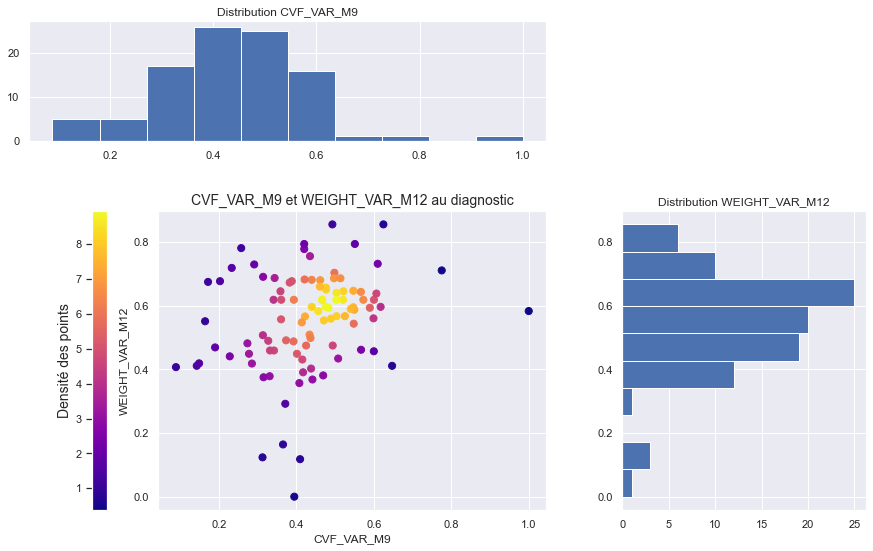

In [8]:
# define cluster variable
variables = ['CVF_VAR_M9', 'WEIGHT_VAR_M12']

# Get data from cluster variables
df_tmp = X_scaled[variables].dropna()
v1 = df_tmp[variables[0]]
v2 = df_tmp[variables[1]]

# Calculate the point density
v12 = np.vstack([v1,v2])
z = gaussian_kde(v12)(v12)
norm = mpl.colors.Normalize(vmin=min(z),vmax=max(z))

# Prepare figure
fig = plt.figure(figsize=([15, 9]))

gs = GridSpec(4, 4, wspace=0.5, hspace=1, width_ratios=[1,1,1,2], height_ratios=[3,1,1,2])
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0,0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

# Plot scatter plot
ax_scatter.scatter(v1, v2, c=z, cmap=cm.plasma, s=50)
ax_scatter.set_title(v1.name + ' et ' + v2.name + ' au diagnostic', fontsize=14)
ax_scatter.set_xlabel(v1.name)
ax_scatter.set_ylabel(v2.name)

# Plot colorbar
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.plasma), location='left', ax=ax_scatter)
cbar.set_label('Densité des points', fontsize=14)

# Plot horizontal histogram
ax_hist_x.hist(v2, orientation='horizontal')
ax_hist_x.set_title('Distribution ' + v2.name)

# Plot vertical histogram
ax_hist_y.hist(v1)
ax_hist_y.set_title('Distribution ' + v1.name)

plt.show()

## Show estimated density from variables

C:\Users\guill\AppData\Local\Temp/ipykernel_2480/1922869008.py:26: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels,loc="upper right")


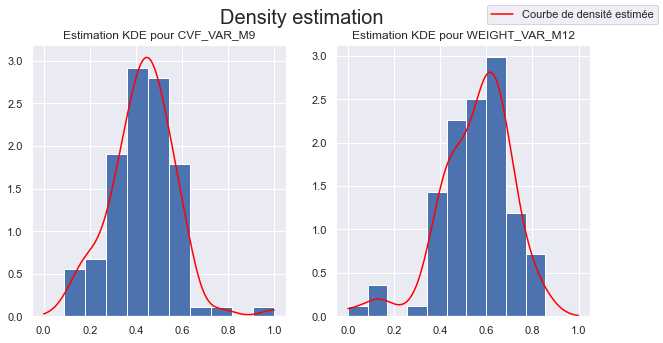

Nombre de patients : 98


In [9]:
# Prepare figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5) ,gridspec_kw={'width_ratios': [10, 10]})

# KDE for x axis
scipy_kernel = gaussian_kde(v1)

u = np.linspace(0, 1, 500)
v = scipy_kernel.evaluate(u)

ax1.hist(v1, density=True)
l2 = ax1.plot(u, v, color='red')
ax1.set_title('Estimation KDE pour ' + v1.name)

# KDE for y axis
scipy_kernel = gaussian_kde(v2)

u = np.linspace(0, 1, 500)
v = scipy_kernel.evaluate(u)

ax2.hist(v2, density=True)
l1 = ax2.plot(u, v, color='red')
ax2.set_title('Estimation KDE pour ' + v2.name)

# Add legend
labels = ['Courbe de densité estimée']
fig.legend([l1, l2], labels=labels,loc="upper right")
plt.suptitle("Density estimation", fontsize=20)
plt.show()

print("Nombre de patients :", df_tmp.shape[0])

# Kmedoid

## Setup

In [10]:
# Make a copy of the dataframe
df_tmp = X_scaled.copy()

# define cluster variable
variables_cluster = ['WEIGHT_VAR_M12', 'CVF_VAR_M12']

# If there is just one variable
if len(variables_cluster) == 1:
    # add temporary y axis variable set to zero
    df_tmp['y'] = np.zeros(len(df_tmp.copy())).copy()
    # Set variable to be evaluated
    variables_cluster = [variables_cluster[0], 'y']
    

# Drop nan values
df_tmp = df_tmp[variables_cluster].dropna()

# Set x and y axis
v1 = df_tmp[variables_cluster[0]]
v2 = df_tmp[variables_cluster[1]]
# If third variable, set z axis
if len(variables_cluster) == 3:
    v3 = df_tmp[variables_cluster[2]]

# Metric used
metric = "manhattan"

# define clusters colors
colors = ['#DF2020', '#803090', '#009900', '#999900', '#504020', '#500000']

## Set cluster assignement for each data point

In [11]:
# Number of clusters to look for
n_clusters = 2

# Set up clustering method
kmedoids = KMedoids(n_clusters=n_clusters, metric=metric)
df_tmp['cluster'] = kmedoids.fit_predict(df_tmp[variables_cluster])

# Get predicted coordinates centroids for each axis
centroids = kmedoids.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
if len(variables_cluster) == 3:
    cen_z = [i[2] for i in centroids]

# Centroid values axis set
cen_x_set = {}
cen_y_set = {}
if len(variables_cluster) == 3:
    cen_z_set = {}
    
# Colors set
colors_set = {}

# For each cluster
for i in range(0, kmedoids.n_clusters):
    
    # add mapper to which centroid values axis the cluster i belong
    cen_x_set.update({i:cen_x[i]})
    cen_y_set.update({i:cen_y[i]})
    if len(variables_cluster) == 3:
        cen_z_set.update({i:cen_z[i]})
        
    # Set a color for the cluster i
    colors_set.update({i:colors[i]})
    
    # Set to which cluster belong each points
    df_tmp['cen_x'] = df_tmp.cluster.map(cen_x_set)
    df_tmp['cen_y'] = df_tmp.cluster.map(cen_y_set)
    if len(variables_cluster) == 3:
        df_tmp['cen_z'] = df_tmp.cluster.map(cen_z_set)
    df_tmp['c'] = df_tmp.cluster.map(colors_set)

## Plot Clusters and Evaluation

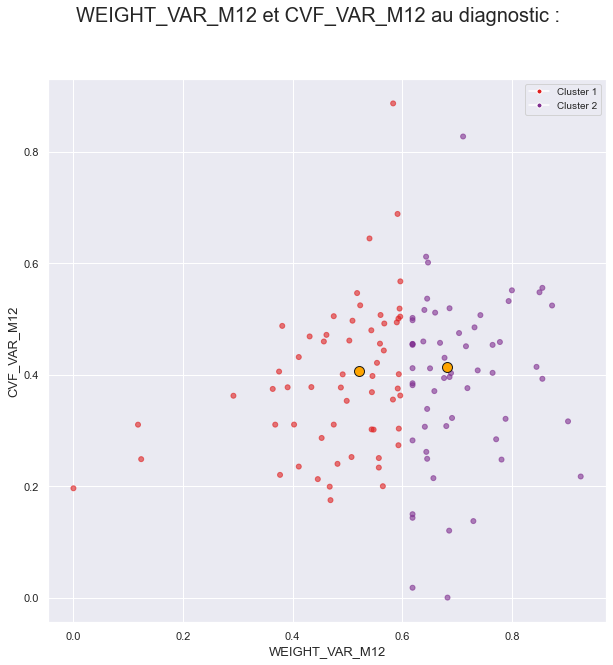

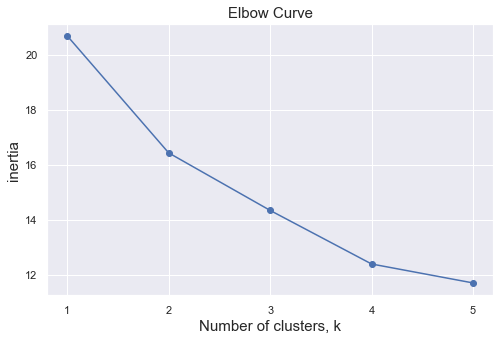

Score silhouette :  0.28946171219294276
Nombre de patients : 119


In [12]:
# ==============================
# Plot data points with clusters
# ==============================

fig = plt.figure(figsize=(10, 10))

# Set main title
if len(variables_cluster) == 3:
    plt.suptitle(v1.name + ', ' + v2.name + ' et ' + v3.name + ' au diagnostic :', fontsize=20)
else:
    plt.suptitle(v1.name + ' et ' + v2.name + ' au diagnostic :', fontsize=20)

# set up the axes for the first plot
if len(variables_cluster) == 3:
    ax = fig.add_subplot(projection='3d')
else:
    ax = fig.add_subplot()

# Set Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors[0:kmedoids.n_clusters])]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Plot titles and labels
ax.set_xlabel(v1.name, fontsize=13)
ax.set_ylabel(v2.name, fontsize=13)
if len(variables_cluster) == 3:
    ax.set_zlabel(v3.name, fontsize=13)
    # Set orientation
    ax.view_init(elev=15, azim=40)

# plot data points
if len(variables_cluster) == 3:
    ax.scatter(v1, v2, v3, c=df_tmp.c, alpha = 0.6, s=25)
else:
    ax.scatter(v1, v2, c=df_tmp.c, alpha = 0.6, s=25)

# Plot centroids from each cluster
if len(variables_cluster) == 3:
    ax.plot( kmedoids.cluster_centers_[:, 0], kmedoids.cluster_centers_[:, 1], kmedoids.cluster_centers_[:, 2], 'o', 
        markerfacecolor='orange',
        markeredgecolor='k',
        markersize=10,
    );
else:
     ax.plot( kmedoids.cluster_centers_[:, 0], kmedoids.cluster_centers_[:, 1], 'o', 
        markerfacecolor='orange',
        markeredgecolor='k',
        markersize=10,
    );

# ==============================
# Plot Elbow Evaluation
# ==============================        

# set up the axes for the second plot
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()

ks = range(1, 6)
inertias = []

for k in ks:

    model = KMedoids(n_clusters=k)

    # Fit model to samples
    model.fit(df_tmp[variables_cluster])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot ks vs inertias
ax.plot(ks, inertias, '-o')
ax.set_title("Elbow Curve", fontsize=15)
ax.set_xlabel('Number of clusters, k', fontsize=15)
ax.set_ylabel('inertia', fontsize=15)
ax.set_xticks(ks)
plt.show()

# Display Silhouette score
print('Score silhouette : ', silhouette_score(df_tmp[variables_cluster], kmedoids.fit_predict(df_tmp[variables_cluster]), metric=metric))
print("Nombre de patients :", df_tmp.shape[0])

# Labelling

## Setup

In [50]:
# Numeric variables names
variables = ['CVF_VAR_M6']

# copy dataframe
df_tmp = X.copy()

# If it's univariate
if len(variables) == 1:
    # add temporary y axis variable set to zero
    df_tmp['y'] = np.zeros(len(df_tmp.copy())).copy()
    # Set variable to be evaluated
    variables = [variables[0], 'y']

# Get temporary dataframe with cluster variables
df_tmp = df_tmp[variables]
    
# Add label that will allow to label our points
df_tmp['Label'] = y

# Drop null values
df_tmp = df_tmp.dropna()

# Set x and y axis
v1 = df_tmp[variables[0]]
v2 = df_tmp[variables[1]]
if len(variables) == 3:
    v3 = df_tmp[variables[2]]

# Get unique values from the label variable
unique_values = np.unique(df_tmp['Label'])

# define map colors for data points
colors = ['#DF2020', '#81DF20', '#005544', '#009944', '#990044', '#990099', '#992000']

# Set 
map_set = {}

# For each unique value from the label variable
for i in range(0, len(unique_values)):
    # Map to his respective color for all concerned data points that have this label value
    map_set.update({unique_values[i]:colors[i]})
    
# Add column that will contains label colors for each data points
df_tmp['c'] = y.map(map_set)

## Plot data

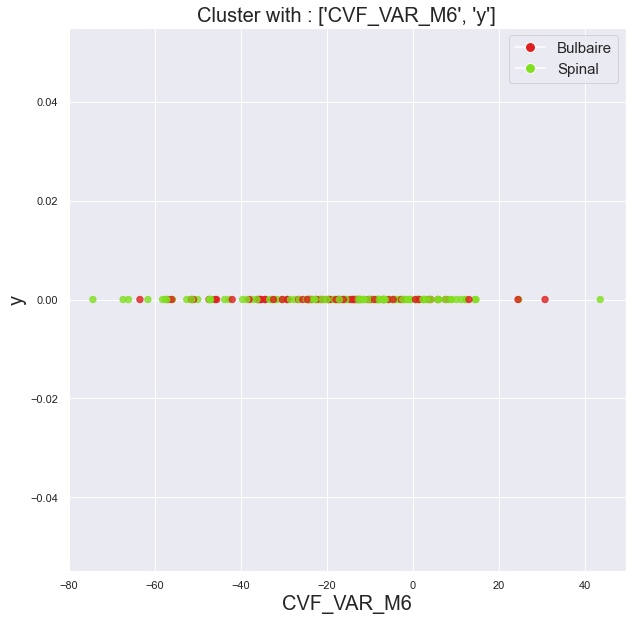

Nombre de patients : 198


In [51]:
# Create figure
fig = plt.figure(figsize=(10, 10))

# Add subplot
if len(variables) == 3:
    ax = fig.add_subplot(projection='3d')
else:
    ax = fig.add_subplot()

# Set up Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=unique_values[i], 
               markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors[0:len(unique_values)])]
# plot legend
plt.legend(handles=legend_elements, loc='upper right', fontsize=15)

# plot data points
if len(variables) == 3:
    ax.scatter(v1, v2, v3, c=df_tmp.c, alpha = 0.8, s=40)
    # View Orientation
    ax.view_init(elev=15, azim=45)
else:
    ax.scatter(v1, v2, c=df_tmp.c, alpha = 0.8, s=40)
    
# Plot axis names
ax.set_xlabel(v1.name, fontsize=20)
ax.set_ylabel(v2.name, fontsize=20)
if len(variables) == 3:
    ax.set_zlabel(v3.name)

plt.title("Cluster with : " + str(variables), fontsize=20)
plt.show()

print("Nombre de patients :", df_tmp.shape[0])